In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
import urllib.request


**Homework 3** <br>
**Explaianble AI Fall 2025**

**Total points:** 20 (20 + 1 bonus pt)<br>
**Overall Goal:** Explainability and Interpretation of Image Classifiers<br>
**Due:** End of Semester

**Notes:**
* complete in colab or on your own local jupyter notebook
* submission is file upload (download your notebook as a .pynb)
* sample dataset can be found in canvass files: 'HW1 files/'



**2pts**<br>
**1.** Using a CNN to classify an image. 

**A.** Provided is a model generated image. Load in resnet model and list the top 3 classifications for the given image (1pt)


In [4]:
import requests
# Load a pretrained ResNet model
resnet = models.resnet50(pretrained=True)
resnet.eval()  # set to evaluation mode

# Load ImageNet class labels
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(LABELS_URL).text.splitlines()

# Prepare the image (replace 'your_image.jpg' with your actual image path)
image_path = 'generated_image.png'
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # add batch dimension

# Make prediction
with torch.no_grad():
    output = resnet(input_batch)

# Get probabilities
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get top 3 predictions
top3_prob, top3_catid = torch.topk(probabilities, 3)

# Print results
for i in range(top3_prob.size(0)):
    print(f"{labels[top3_catid[i]]}: {top3_prob[i].item():.4f}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tennis ball: 0.9718
golden retriever: 0.0270
racket: 0.0007


**B.** What observations can draw from the top 3 classifications (1pt)


It was heavily influenced towards tennis ball which is somewhat correct but in my opinion the golden retriever is more prevalent. It's interesting to see that racket was 3rd in the classification rank since there is no racket in the image at all.

**2.** Vanilla Saliency (6pts)
<br>

**A.** Visualize the ROI using Vanilla Saliency (3pts)<br>

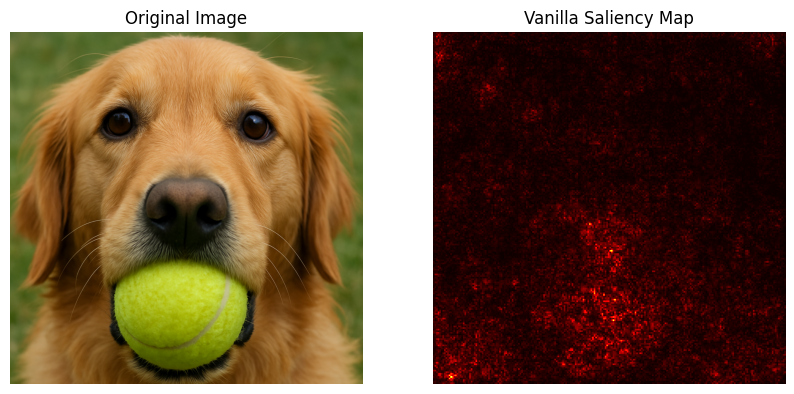

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Enable gradients on the input image
input_tensor.requires_grad_()

# Forward pass again (without torch.no_grad)
output = resnet(input_tensor.unsqueeze(0))
pred_class = output.argmax(dim=1)

# Backward pass: compute gradients w.r.t. top predicted class
output[0, pred_class].backward()

# Get the saliency map (max absolute gradient across RGB channels)
saliency, _ = torch.max(input_tensor.grad.data.abs(), dim=0)
saliency = saliency.cpu().numpy()

# Normalize for visualization
saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))

# Plot original image and saliency map
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

# Saliency map
plt.subplot(1, 2, 2)
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.title('Vanilla Saliency Map')

plt.show()


**B.** Interpret the Results (3pts)<br>
consider the following:

* What area was highlighted?

* Did this help you to formalate an explanation/interpretation of the classification given in question 1?


The lower middle area was highlighted the most in this imagery which helps interpret why the top classification for the image was a tennis ball.

**3.** Gradcam (6pts)

**A.** Visualize the ROI using Gradcam (3pts)<br>

In [9]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

# Get the last convolutional layer (for ResNet50, it's layer4)
final_conv = resnet.layer4

# Hook to store gradients and activations
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)

# Register hooks
forward_handle = final_conv.register_forward_hook(forward_hook)
backward_handle = final_conv.register_backward_hook(backward_hook)

# Forward pass
output = resnet(input_tensor.unsqueeze(0))
pred_class = output.argmax(dim=1)

# Backward pass
resnet.zero_grad()
output[0, pred_class].backward()

# --------- Step 7: Compute Grad-CAM ---------
#Get saved activations and gradients for the input image
#These were stored via forward and backward hooks on the last conv layer
##uncomment
grad = gradients[0].detach()
act = activations[0].detach()

#Global average pooling on gradients to get weights (αₖ)
#This gives the importance of each feature map for the target class
##uncomment
weights = grad.mean(dim=(2, 3), keepdim=True)  # Global avg pooling

###Weighted sum of activations###
# Multiply each feature map by its corresponding weight, then sum them
##uncomment
grad_cam = F.relu((weights))

##Upsample the Grad-CAM heatmap to the input image size
grad_cam = F.interpolate(grad_cam, size=(224, 224), mode='bilinear', align_corners=False)

##Remove extra dimensions and convert to NumPy array for visualization
grad_cam = grad_cam.squeeze().numpy()

# --------- Step 8: Normalize for heatmap ---------
grad_cam -= grad_cam.min()
grad_cam /= grad_cam.max()

In [12]:
# --------- Step 9: Load ImageNet class labels ---------
##uncomment
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels_path = "imagenet_classes.txt"

# # Download if not already present
try:
    with open(labels_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]
except FileNotFoundError:
    urllib.request.urlretrieve(url, labels_path)
    with open(labels_path, "r") as f:
        classes = [line.strip() for line in f.readlines()]

predicted_label = classes[pred_class]
print(f"Predicted Class: {predicted_label} (index: {pred_class})")

Predicted Class: tennis ball (index: tensor([852]))


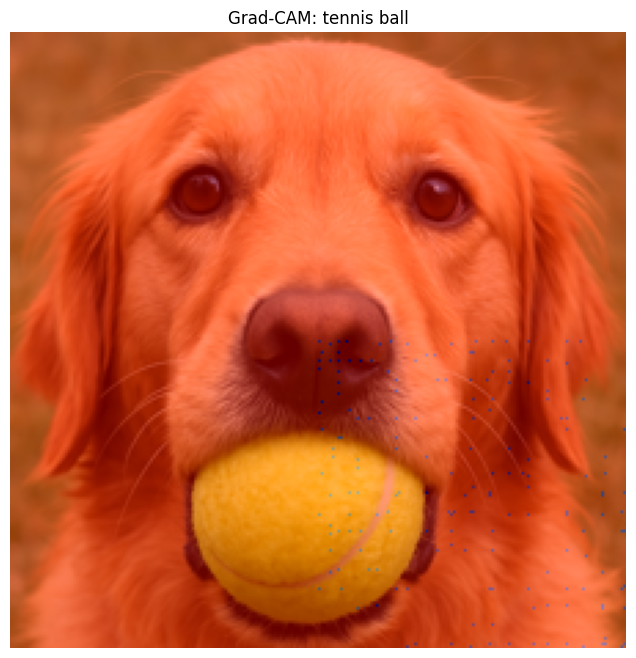

In [17]:
# --------- Step 10: Create heatmap and overlay ---------
##uncomment
# # Resize original image
img_resized = image.resize((224, 224))
img_np = np.array(img_resized) / 255.0  # Normalize to [0, 1]


heatmap_2d = np.mean(grad_cam, axis = 0)

heatmap_2d = (heatmap_2d - np.min(heatmap_2d)) / (np.max(heatmap_2d) - np.min(heatmap_2d))

# # Create colored heatmap using matplotlib
heatmap_colored = plt.cm.jet(heatmap_2d)[:, :, :3]  # Remove alpha channel  

# # Blend heatmap and original image
overlay = 0.8 * heatmap_colored + 0.8 * img_np
overlay = np.clip(overlay, 0, 1)

# # --------- Step 8: Display the result ---------
plt.figure(figsize=(8, 8))
plt.imshow(overlay)
plt.title(f"Grad-CAM: {predicted_label}")
plt.axis("off")
plt.show()


**B.** Interpret the Results (3pts)<br>
consider the following:

* What area was highlighted?
* Was this different from Vanilla Saliency?
* Did this help you to update your explanation/interpretation of the classification given in question 1?


The whole image in general was highlighted which I'm not sure if it's how grad-cam is working for this image example or if there is something wrong on my end. Assuming the former, it is different from vanilla saliency but hasn't help update the interpretation of my classification.

**3.** Layer wise Relevance Propegation (6pts)

**A.** Visualize the ROI using LRP(3pts)<br>

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


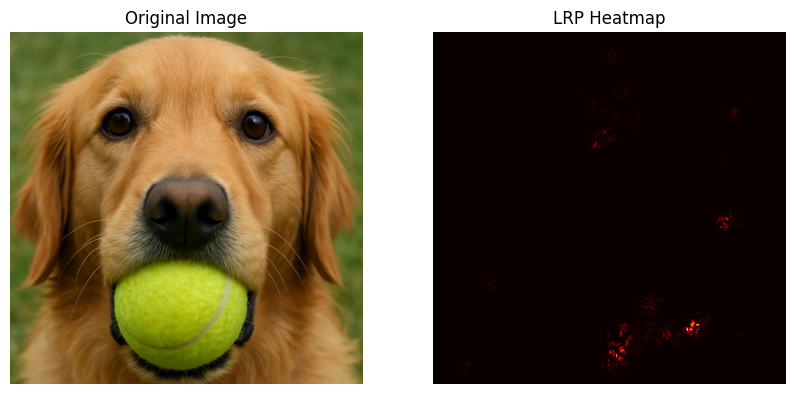

In [18]:
from captum.attr import LRP

# Make sure the model is in eval mode
resnet.eval()

# Set up LRP explainer
lrp = LRP(resnet)

# Compute LRP attributions (use the predicted class)
attributions = lrp.attribute(input_tensor.unsqueeze(0), target=pred_class)

# Convert attributions: [1, 3, H, W] → [H, W]
attributions = attributions.squeeze().permute(1, 2, 0).detach().cpu().numpy()
attributions = np.sum(attributions, axis=2)  # sum over RGB channels
attributions = np.maximum(attributions, 0)   # keep positive relevance only

# Normalize for visualization
attributions = (attributions - np.min(attributions)) / (np.max(attributions) - np.min(attributions))

# Plot original image and LRP map
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

# LRP heatmap
plt.subplot(1, 2, 2)
plt.imshow(attributions, cmap='hot')
plt.axis('off')
plt.title('LRP Heatmap')

plt.show()


**B.** Interpret the Results (3pts)<br>
consider the following:

* What area was highlighted?
* Was this different from Vanilla Saliency and Gradcam?
* Did this help you to update your explanation/interpretation of the classification given in question 1?


The area that's highlighted the most is towards the bottom right but mot all the way to the bottom. This was different from the previous ones as well and makes less sense trying to include in my interpretation. The area that it is mainly highlighting is nothing notable that would heavily effect the classification in my opinion.

**Bonus** (+1pt)<br>
Use a model agnostic method (Lime, Shap, etc)</br>
A. Visulize the ROI <br>
B. Interpret your results

In [19]:
## normalizes the image pixel values using the mean and standard 
## deviation of the ImageNet dataset.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## format (C x H x W, where C=3 for RGB)
##add an exter dim for batch process -even though its only one image
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [ ]:
# Function to predict from model
def predict_fn(images):
    images = np.stack([transform(Image.fromarray(img.astype(np.uint8))) for img in images])
    images = torch.tensor(images, dtype=torch.float32)
   

In [ ]:
 
    with torch.no_grad():
        outputs = resnet(images)
    
    return torch.nn.functional.softmax(outputs, dim=1).numpy()

100%|██████████| 1000/1000 [00:34<00:00, 29.39it/s]


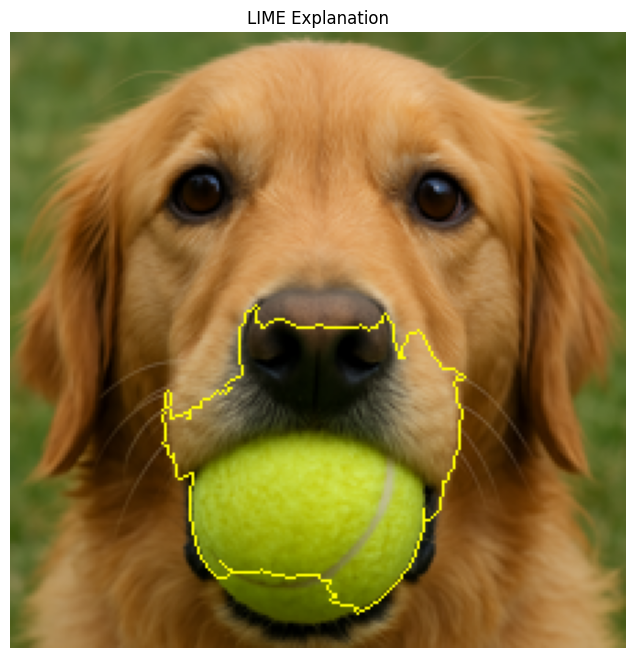

In [22]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

# LIME explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(image.resize((224, 224))),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

# Get explanation mask for the top class
top_label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(top_label, positive_only=True, num_features=5, hide_rest=False)

# Visualize the LIME explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp, mask))
plt.axis("off")
plt.title("LIME Explanation")
plt.show()

The lime explanation is primarily around the tennis ball and part of the dogs mouth but is mainly is around the tennis ball. This helps interpret the classification of a tennis ball.